<a href="https://colab.research.google.com/github/CopurOnur/Data-Augmentation-Tutorial/blob/main/Advanced_AI_Tensorflow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


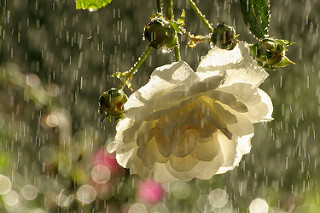

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

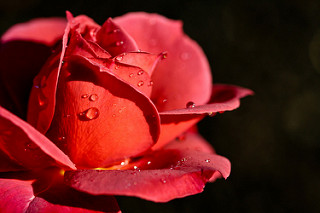

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset.

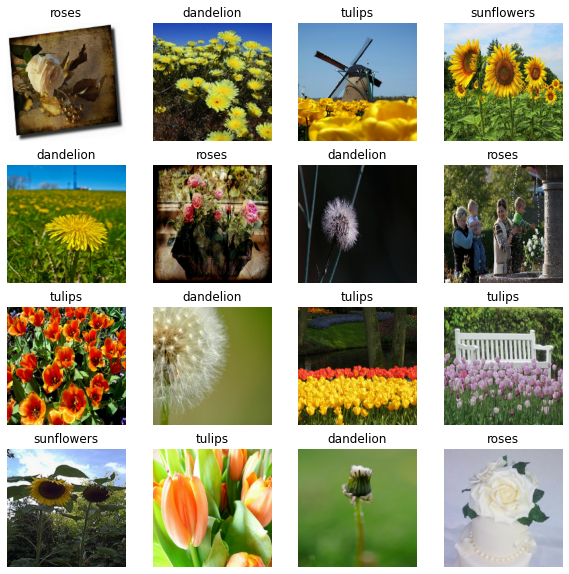

In [10]:
"""(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)"""
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
#get_label_name = metadata.features['label'].int2str
sample=0
image, label = next(iter(train_ds.take(1)))


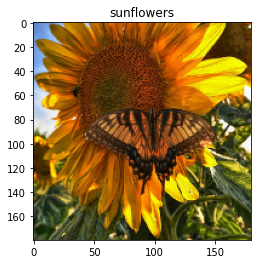

In [12]:
image = image[sample].numpy().astype("uint8")
label_inter = label[sample]
label = train_ds.class_names[label[sample]]
image_inter = image.copy()
_ = plt.imshow(image_inter)
_ = plt.title(label)

## Use Keras preprocessing layers

### Resizing and rescaling


You can use the Keras preprocessing layers to resize your images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [13]:
from tensorflow.keras import layers
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.


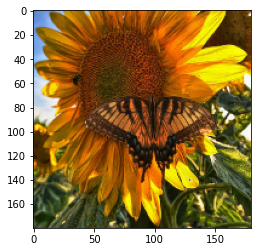

In [14]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Verify that the pixels are in the `[0, 1]` range:

In [15]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as `tf.keras.layers.RandomFlip` and `tf.keras.layers.RandomRotation`.

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [17]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [18]:
image.shape

TensorShape([1, 180, 180, 3])

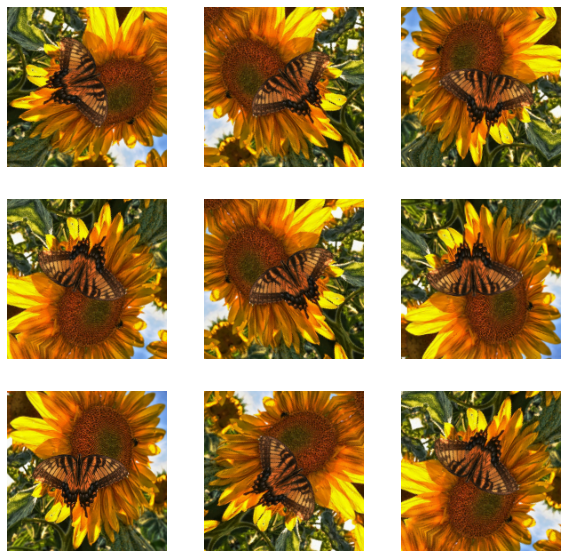

In [19]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a `tf.keras.layers.Lambda` layer. This is a good way to write concise code.
- Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control.

Both layers will randomly invert the colors in an image, according to some probability.

In [20]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [21]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

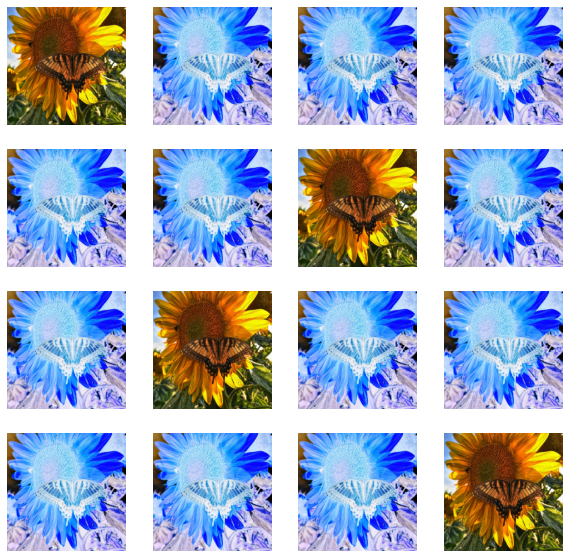

In [22]:
plt.figure(figsize=(10, 10))
for i in range(16):
  augmented_image = random_invert(image)
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [23]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

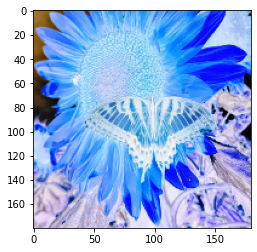

In [24]:
_ = plt.imshow(RandomInvert()(image)[0].numpy().astype("uint8"))

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  RandomInvert()
])

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model

In [26]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` (not `Model.evaluate` or `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [27]:
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. (Learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.)

Note: Data augmentation should only be applied to the training set.

In [28]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [29]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [31]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 30s 221ms/step - loss: 19.4464 - accuracy: 0.2565 - val_loss: 1.4671 - val_accuracy: 0.3896
Epoch 2/5
92/92 [==============================] - 12s 118ms/step - loss: 1.5256 - accuracy: 0.3154 - val_loss: 1.3356 - val_accuracy: 0.4196
Epoch 3/5
92/92 [==============================] - 11s 117ms/step - loss: 1.6777 - accuracy: 0.3215 - val_loss: 1.2774 - val_accuracy: 0.4441
Epoch 4/5
92/92 [==============================] - 12s 118ms/step - loss: 1.4825 - accuracy: 0.3505 - val_loss: 1.2345 - val_accuracy: 0.4905
Epoch 5/5
92/92 [==============================] - 12s 117ms/step - loss: 1.4281 - accuracy: 0.3791 - val_loss: 1.0487 - val_accuracy: 0.6022


In [34]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 60ms/step - loss: 1.0641 - accuracy: 0.5341
Accuracy 0.5340599417686462


## Using tf.image

Let's use the following function to visualize and compare the original and augmented images side-by-side:

In [35]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

#### Flip an image

Flip an image either vertically or horizontally with `tf.image.flip_left_right`:

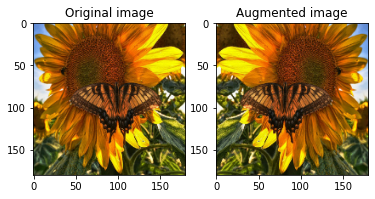

In [36]:
image = image[0].numpy().astype("uint8")
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale an image

You can grayscale an image with `tf.image.rgb_to_grayscale`:

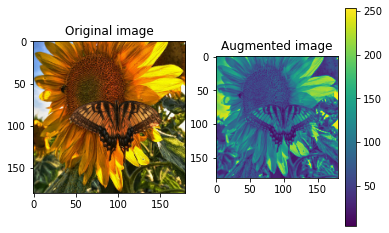

In [37]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate an image

Saturate an image with `tf.image.adjust_saturation` by providing a saturation factor:

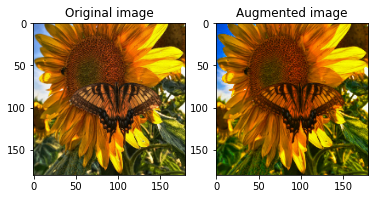

In [38]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness

Change the brightness of image with `tf.image.adjust_brightness` by providing a brightness factor:

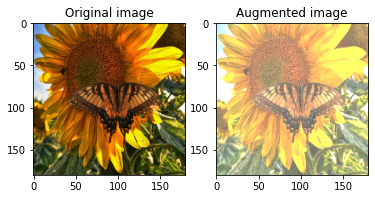

In [39]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop an image

Crop the image from center up to the image part you desire using `tf.image.central_crop`:

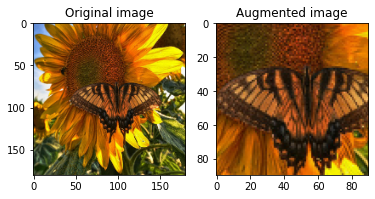

In [40]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### Rotate an image

Rotate an image by 90 degrees with `tf.image.rot90`:

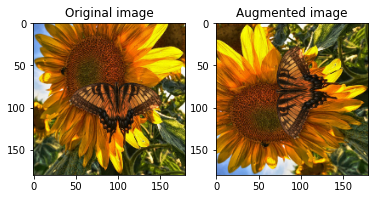

In [41]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### Randomly change image brightness

Randomly change the brightness of `image` using `tf.image.stateless_random_brightness` by providing a brightness factor and `seed`. The brightness factor is chosen randomly in the range `[-max_delta, max_delta)` and is associated with the given `seed`.

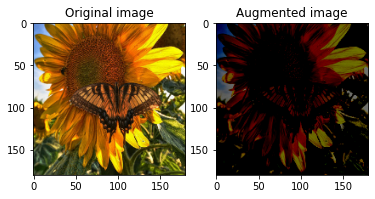

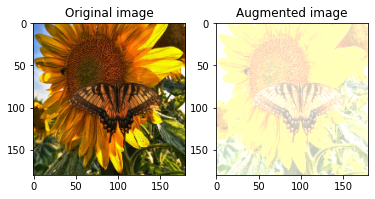

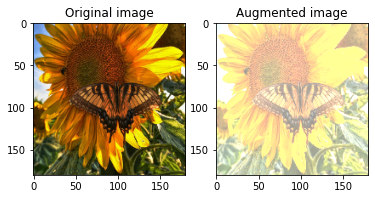

In [42]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### Randomly change image contrast

Randomly change the contrast of `image` using `tf.image.stateless_random_contrast` by providing a contrast range and `seed`. The contrast range is chosen randomly in the interval `[lower, upper]` and is associated with the given `seed`.

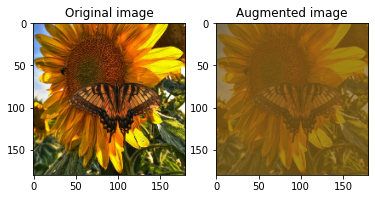

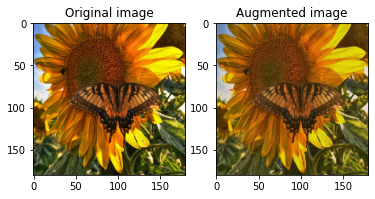

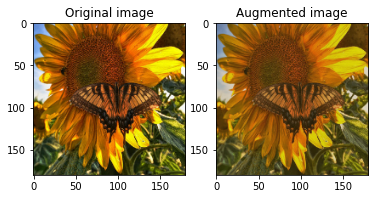

In [43]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

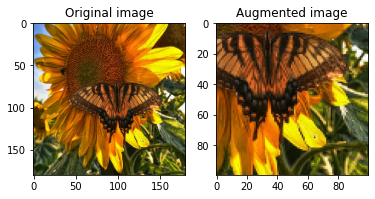

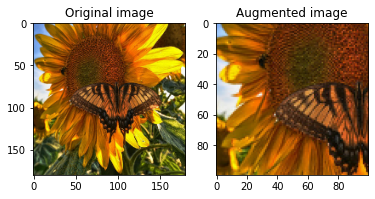

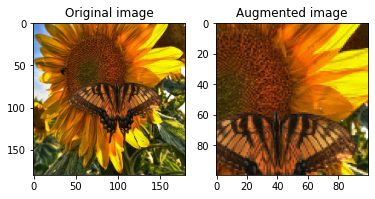

In [44]:
for i in range(3):
  seed = (i, 10)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[100, 100, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

Let's first download the image dataset again in case they are modified in the previous sections.

In [45]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

'tulips'

In [68]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [46]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define the `augment` function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [47]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Option 2: Using tf.random.Generator

- Create a `tf.random.Generator` object with an initial `seed` value. Calling the `make_seeds` function on the same generator object always returns a new, unique `seed` value.
- Define a wrapper function that: 1) calls the `make_seeds` function; and 2) passes the newly generated `seed` value into the `augment` function for random transformations.

Note: `tf.random.Generator` objects store RNG state in a `tf.Variable`, which means it can be saved as a [checkpoint](../../guide/checkpoint.ipynb) or in a [SavedModel](../../guide/saved_model.ipynb). For more details, please refer to [Random number generation](../../guide/random_numbers.ipynb).

In [48]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [49]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

Map the wrapper function `f` to the training dataset, and the `resize_and_rescale` function—to the validation and test sets:

In [50]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [51]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [52]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 9s 83ms/step - loss: 1.1493 - accuracy: 0.5259 - val_loss: 0.9527 - val_accuracy: 0.6431
Epoch 2/15
92/92 [==============================] - 5s 58ms/step - loss: 1.0217 - accuracy: 0.6069 - val_loss: 0.9035 - val_accuracy: 0.6703
Epoch 3/15
92/92 [==============================] - 5s 59ms/step - loss: 0.9208 - accuracy: 0.6386 - val_loss: 0.8918 - val_accuracy: 0.6894
Epoch 4/15
92/92 [==============================] - 6s 60ms/step - loss: 0.7805 - accuracy: 0.7037 - val_loss: 0.9558 - val_accuracy: 0.6431
Epoch 5/15
92/92 [==============================] - 6s 60ms/step - loss: 0.6736 - accuracy: 0.7476 - val_loss: 0.8824 - val_accuracy: 0.6921
Epoch 6/15
92/92 [==============================] - 5s 60ms/step - loss: 0.5536 - accuracy: 0.7936 - val_loss: 0.9458 - val_accuracy: 0.7248
Epoch 7/15
92/92 [==============================] - 5s 59ms/step - loss: 0.4125 - accuracy: 0.8525 - val_loss: 1.0781 - val_accuracy: 0.6785
Epoch 8/15
92

In [55]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 1s 84ms/step - loss: 1.5755 - accuracy: 0.6866
Accuracy 0.6866484880447388


# Interpretable Machine Learning

In [56]:
!pip install lime

In [57]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import cv2
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

In [58]:
def exp_mask(x,y):
  image_inter = x
  label_inter = y
  explanation = explainer.explain_instance(image_inter.astype('double'), 
                                         classifier_fn = model.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000, segmentation_fn=segmenter)
  
  temp, mask = explanation.get_image_and_mask(y, positive_only=True, num_features=10, hide_rest=True)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

sunflowers
sunflowers


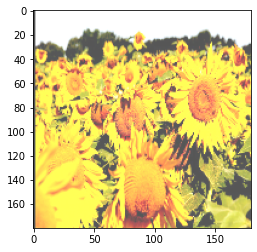

In [77]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
plt.imshow(image[0])
print(metadata.features['label'].int2str(label[0].numpy()))
pred = model.predict(image)[0]
print(metadata.features['label'].int2str(pred.argmax()))

/usr/local/lib/python3.7/dist-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

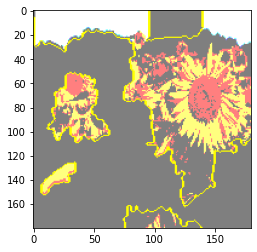

In [78]:
exp_mask(image[0].numpy().astype("uint8"),label[0].numpy())
#exp_mask(image_inter,label_inter.numpy())